# Experimentación con GMM

In [165]:
import numpy as np
from sklearn.cluster import KMeans as SKMeans
import GMM
from importlib import reload
import seaborn as sns
import matplotlib.pyplot as plt
from kmeans_plus_plus import KMeans
from sklearn.model_selection import ParameterGrid
import pandas as pd

# Utils

In [181]:
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score, mutual_info_score, normalized_mutual_info_score

def calculate_clustering_metrics(X, cluster_labels, true_labels):
    
    silhouette = silhouette_score(X, cluster_labels)  # Silhouette Score
    rand_index = rand_score(true_labels, cluster_labels)  # Rand Index
    adjusted_rand = adjusted_rand_score(true_labels, cluster_labels)  # Adjusted Rand Index
    mutual_info = mutual_info_score(true_labels, cluster_labels)  # Mutual Information
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)  # Normalized Mutual Information
    
    metrics = {
        "silhouette": silhouette,
        "rand_index": rand_index,
        "rand_index_adjusted": adjusted_rand,
        "mutual_info": mutual_info,
        "mutual_info_normalized": nmi
    }

    return metrics
def load_features_ids_labels(filename:str, has_labels=True):
    """
    Description:
        Cargar los features, ids y labels de un archivo npz.
        Si es data de testeo, has_labels=False
    """
    contents = np.load(filename, allow_pickle=True)
    features = contents['features']
    ids = contents['ids']
    if has_labels:
        labels = contents['labels']
        return features, ids, labels
    return features, ids

# Load Data

In [134]:
train_tsne_2d = np.load('reduction/train/train_tsne_2d.npy')
test_tsne_2d = np.load('reduction/test/test_tsne_2d.npy')
val_tsne_2d = np.load('reduction/val/val_tsne_2d.npy')

train_tsne_3d = np.load('reduction/train/train_tsne_3d.npy')
test_tsne_3d = np.load('reduction/test/test_tsne_3d.npy')
val_tsne_3d = np.load('reduction/val/val_tsne_3d.npy')

train_umap_2d = np.load('reduction/train/train_umap_2d.npy')
test_umap_2d = np.load('reduction/test/test_umap_2d.npy')
val_umap_2d = np.load('reduction/val/val_umap_2d.npy')

train_umap_3d = np.load('reduction/train/train_umap_3d.npy')
test_umap_3d = np.load('reduction/test/test_umap_3d.npy')
val_umap_3d = np.load('reduction/val/val_umap_3d.npy')

y_train = np.load('reduction/train_numeric_labels.npy')

_,_, y_val = load_features_ids_labels('features_np/features_val.npz')
del _

In [147]:
unique_labels, y_val_encoded = np.unique(y_val, return_inverse=True)
y_val_encoded = y_val_encoded.flatten()

# Train KMeans

### Custom implementation (kmeans++)

In [136]:
# 2D t-SNE
kmeans_tsne_2d = KMeans(n_clusters=10, random_state=42)
kmeans_tsne_2d.fit_predict(train_tsne_2d)

# 3D t-SNE
kmeans_tsne_3d = KMeans(n_clusters=10, random_state=42)
kmeans_tsne_3d.fit_predict(train_tsne_3d)

# 2D UMAP
kmeans_umap_2d = KMeans(n_clusters=10, random_state=42)
kmeans_umap_2d.fit_predict(train_umap_2d)

# 3D UMAP
kmeans_umap_3d = KMeans(n_clusters=10, random_state=42)
kmeans_umap_3d.fit_predict(train_umap_3d)

### Scikit-learn implementation

In [169]:
# 2D t-SNE
skmeans_tsne_2d = SKMeans(n_clusters=10, random_state=42)
skmeans_tsne_2d.fit_predict(train_tsne_2d)

# 3D t-SNE
skmeans_tsne_3d = SKMeans(n_clusters=10, random_state=42)
skmeans_tsne_3d.fit_predict(train_tsne_3d)

# 2D UMAP
skmeans_umap_2d = SKMeans(n_clusters=10, random_state=42)
skmeans_umap_2d.fit_predict(train_umap_2d)

# 3D UMAP
skmeans_umap_3d = SKMeans(n_clusters=10, random_state=42)
skmeans_umap_3d.fit_predict(train_umap_3d)


array([5, 5, 3, ..., 7, 9, 3], dtype=int32)

# Plots: cómo debería verse la data después de las predicciones

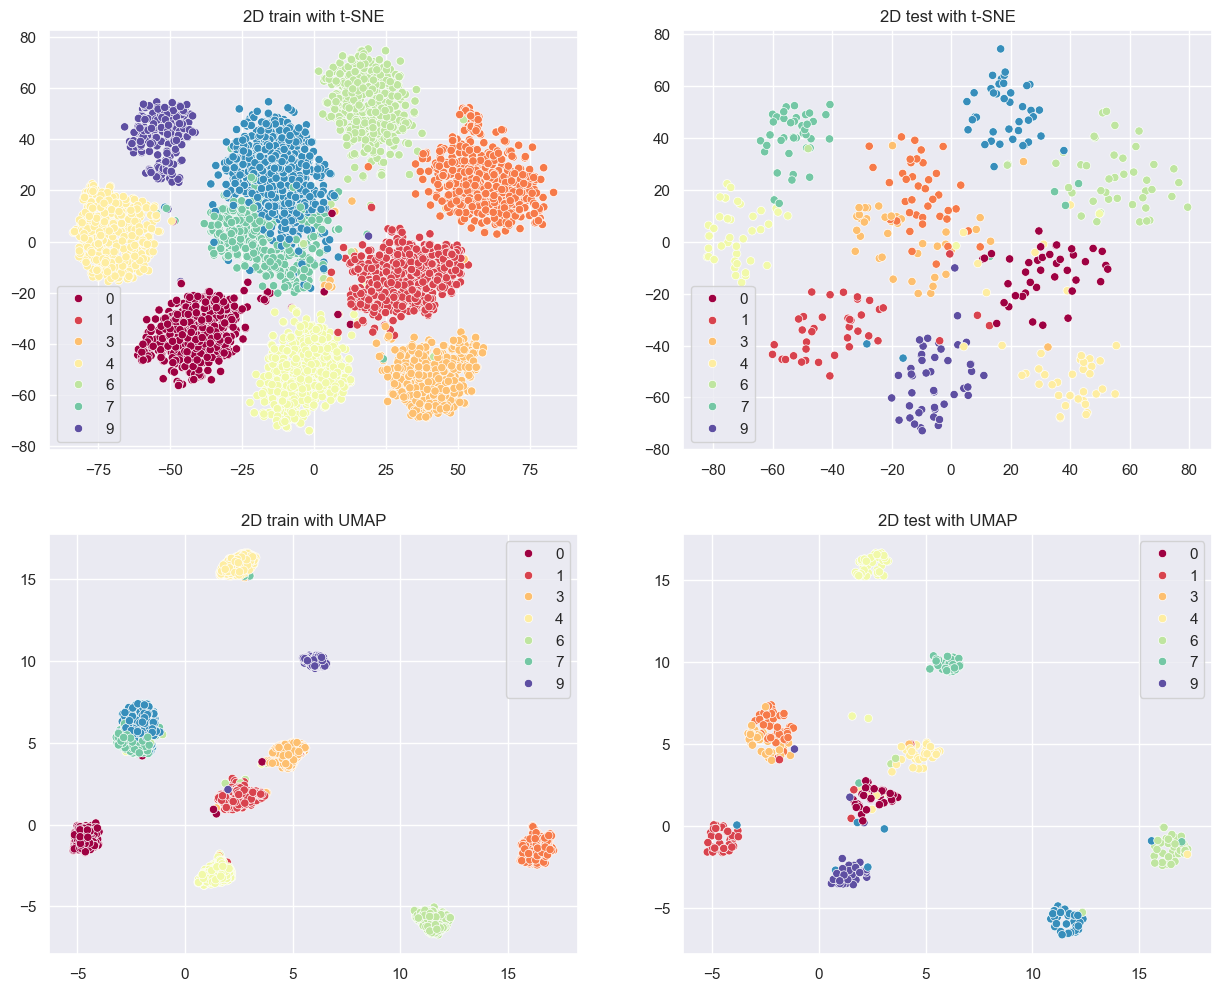

In [193]:
fig, axs= plt.subplots(2, 2, figsize=(15, 12))
sns.scatterplot(x=train_tsne_2d[:,0], y=train_tsne_2d[:,1],hue=y_train,palette='Spectral', ax=axs[0][0])
sns.scatterplot(x=val_tsne_2d[:,0], y=val_tsne_2d[:,1],hue=y_val_encoded,palette='Spectral', ax=axs[0][1])

sns.scatterplot(x=train_umap_2d[:,0], y=train_umap_2d[:,1],hue=y_train,palette='Spectral', ax=axs[1][0])
sns.scatterplot(x=val_umap_2d[:,0], y=val_umap_2d[:,1],hue=y_val_encoded,palette='Spectral', ax=axs[1][1])

axs[0][0].set_title('2D train with t-SNE')
axs[0][1].set_title('2D test with t-SNE')

axs[1][0].set_title('2D train with UMAP')
axs[1][1].set_title('2D test with UMAP')

plt.show()

# GMM

In [170]:
data = {
    'tsne': {
        2: [train_tsne_2d, test_tsne_2d, val_tsne_2d, kmeans_tsne_2d, skmeans_tsne_2d],
        3: [train_tsne_3d, test_tsne_3d, val_tsne_3d, kmeans_tsne_3d, skmeans_tsne_3d],
    },
    'umap': {
        2: [train_umap_2d, test_umap_2d, val_umap_2d, kmeans_umap_2d, skmeans_umap_2d],
        3: [train_umap_3d, test_umap_3d, val_umap_3d, kmeans_umap_3d, skmeans_umap_3d]
    }
}

In [171]:
def experimentation(dim_reduc='tsne', dims=2, knn_implementation='own', n_trials=3):
    records = []
    x_ = data[dim_reduc][dims]
    centroids = None
    if knn_implementation == 'own':
        centroids = x_[3].centroids
    else:
        centroids = x_[4].cluster_centers_
    i = 0
    while i < n_trials:
        try:
            gmm = GMM.GMM(n_clusters=10, print_freq=200)
            gmm.fit(x_[0], centroids=centroids)
            pred = gmm.predict(X=x_[2])
            metrics = calculate_clustering_metrics(X=x_[2], cluster_labels=pred, true_labels=y_val_encoded)
            metrics['dim_reduc'] = dim_reduc
            metrics['n_dims'] = dims
            metrics['knn_implementation'] = knn_implementation
            metrics['n_trial'] = i
            records.append(metrics)
            i+=1
        except Exception as e:
            print("There was an exception. Trying again. ", str(e))
    return records

In [ ]:
results = []

In [ ]:
parameters = {
    'knn_implementation':['own'],
    'dim_reduc':['tsne', 'umap'],
    'dims':[2, 3]
}
for params in ParameterGrid(parameters):
    results_local = experimentation(dim_reduc=params['dim_reduc'], dims=params['dims'], knn_implementation=params['knn_implementation'])
    results = results + results_local

In [ ]:
parameters = {
    'knn_implementation':['scikit-learn'],
    'dim_reduc':['tsne', 'umap'],
    'dims':[2, 3]
}
for params in ParameterGrid(parameters):
    results_local = experimentation(dim_reduc=params['dim_reduc'], dims=params['dims'], knn_implementation=params['knn_implementation'])
    results = results + results_local

# Explore results

In [176]:
df = pd.DataFrame.from_records(results)
df.to_csv('gmm-results/gmm-all.csv', index=False)

In [180]:
summary = df.groupby(['dim_reduc','knn_implementation','n_dims', ]).mean().reset_index().drop(columns=['n_trial'])
summary

,dim_reduc,knn_implementation,n_dims,silhouette,rand_index,rand_index_adjusted,mutual_info,mutual_info_normalized
0,tsne,own,2,0.483183,0.951115,0.741601,1.868213,0.826126
1,tsne,own,3,0.363716,0.954502,0.747708,1.842896,0.804361
2,tsne,scikit-learn,2,0.491269,0.957658,0.769711,1.889109,0.829104
3,tsne,scikit-learn,3,0.351635,0.944954,0.711287,1.807895,0.800220
4,umap,own,2,0.702614,0.963546,0.796067,1.936046,0.843229
5,umap,own,3,0.721150,0.958188,0.767332,1.888687,0.823549
6,umap,scikit-learn,2,0.739187,0.949870,0.737894,1.872089,0.830913
7,umap,scikit-learn,3,0.721623,0.957827,0.765206,1.885790,0.822186


In [184]:
# quitar implementación de scikit ya que mejoró sustancialmente los resultados
summary = summary[summary['knn_implementation'] == 'own'].drop(columns=['knn_implementation'])
summary

,dim_reduc,n_dims,silhouette,rand_index,rand_index_adjusted,mutual_info,mutual_info_normalized
0,tsne,2,0.483183,0.951115,0.741601,1.868213,0.826126
1,tsne,3,0.363716,0.954502,0.747708,1.842896,0.804361
4,umap,2,0.702614,0.963546,0.796067,1.936046,0.843229
5,umap,3,0.721150,0.958188,0.767332,1.888687,0.823549


log likelihood at iteration 0 : -51838.66088677467
Converged at  58 iterations
{'silhouette': np.float32(0.49328655), 'rand_index': np.float64(0.9501574150787075), 'rand_index_adjusted': 0.7345400065042147, 'mutual_info': np.float64(1.870361184831795), 'mutual_info_normalized': np.float64(0.8236825368568348)}


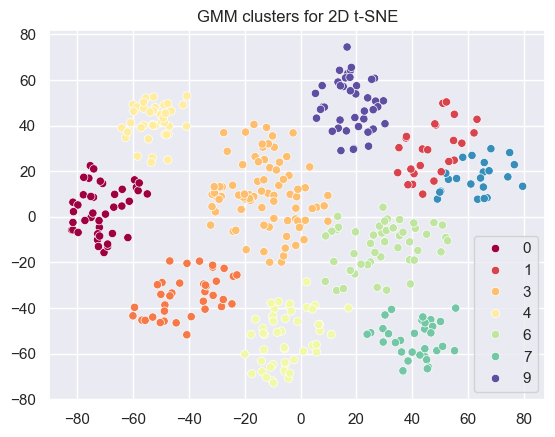

In [190]:
# recrear los mejores resultados ?
# t-SNE 2D
gmm = GMM.GMM(n_clusters=10, print_freq=200)
gmm.fit(train_tsne_2d, centroids=kmeans_tsne_2d.centroids)
pred = gmm.predict(val_tsne_2d)
metrics = calculate_clustering_metrics(X=val_tsne_2d, cluster_labels=pred, true_labels=y_val_encoded)
print(metrics)

sns.scatterplot(x=val_tsne_2d[:,0], y=val_tsne_2d[:,1], hue=pred, palette='Spectral')
plt.title('GMM clusters for 2D t-SNE')
plt.show()

log likelihood at iteration 0 : -17588.987490354753
Converged at  99 iterations
{'silhouette': np.float32(0.7026138), 'rand_index': np.float64(0.9635459817729909), 'rand_index_adjusted': 0.796067496349326, 'mutual_info': np.float64(1.9360458779856244), 'mutual_info_normalized': np.float64(0.8432287723336914)}


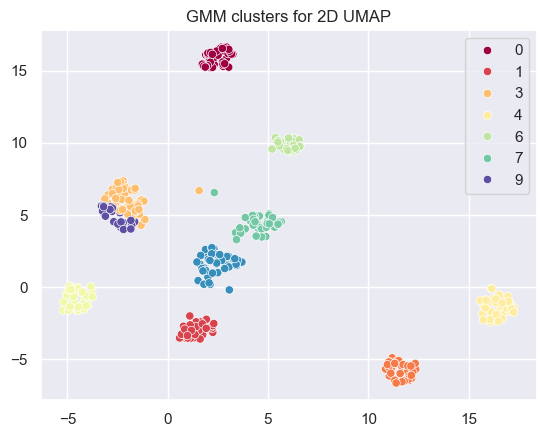

In [191]:
# recrear los mejores resultados ?
# UMAP 2D
gmm = GMM.GMM(n_clusters=10, print_freq=200)
gmm.fit(train_umap_2d, centroids=kmeans_umap_2d.centroids)
pred = gmm.predict(val_umap_2d)
metrics = calculate_clustering_metrics(X=val_umap_2d, cluster_labels=pred, true_labels=y_val_encoded)
print(metrics)

sns.scatterplot(x=val_umap_2d[:,0], y=val_umap_2d[:,1], hue=pred, palette='Spectral')
plt.title('GMM clusters for 2D UMAP')
plt.show()